In [3]:
import numpy as np
import yaml
import plotly.graph_objects as go

# New imports
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.signal import argrelmin

# Peak detection
from peakutils import indexes
from scipy.signal import find_peaks as fp
import scipy

# Lorentzian fit
import matplotlib.pyplot as plt
from lmfit.models import LorentzianModel, QuadraticModel
from lmfit import Model


# Variables
x_dim = 50
y_dim = 50

nr_of_peaks = 6

In [4]:
# Functions to use:

# 2dplot:
def linep2dp(x: np.ndarray, y: list | np.ndarray, yn="", title="", xaxis_title="x", yaxis_title="y") -> None:
    """Multi-line 2D plot using plotly.

    :param x: x-axis values.
    :param yv: y-axis values.
    :param yn: y-axis names.
    :param title: Title of the plot.
    :param xaxis_title: Title of the x-axis.
    :param yaxis_title: Title of the y-axis.
    """

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x, y=y, mode="lines+markers", name=yn))
    fig.update_layout(title=title, xaxis_title=xaxis_title, yaxis_title=yaxis_title)
    fig.show()

# Filter peaks based on difference:
# From optimization dleta_tmp is optimal for value of 80 data point difference

def filter_peaks(peak_exceptions, delta_tmp):
	list_tmp = np.ndarray.tolist(peak_exceptions)
	j = 0
	while j < len(list_tmp)-1:
		if np.abs(list_tmp[j] - list_tmp[j+1]) < delta_tmp:
			list_tmp.pop(j+1)
		else: 
			j = j + 1
	return (np.array(list_tmp))

# Calculate exceptions based on the neighboring values

def average_on_neighbours(peaks):
	for i in range(x_dim):
		for j in range(y_dim):
			if (peaks[i][j][0] == 0):
				sum = np.zeros((nr_of_peaks))
				nr_of_neighbours = np.zeros((nr_of_peaks))
			
				for k in range(nr_of_peaks):
					# left neighbour
					if(i > 0 and i < x_dim):
						sum[k] = sum[k] + peaks[i-1][j][k]
						nr_of_neighbours[k] = nr_of_neighbours[k] + 1
					# right neighbour
					if (i >= 0 and i < (x_dim-1)):
						sum[k] = sum[k] + peaks[i+1][j][k]
						nr_of_neighbours[k] = nr_of_neighbours[k] + 1
					# top neighbour
					if (j > 0 and j < y_dim):
						sum[k] = sum[k] + peaks[i][j-1][k]
						nr_of_neighbours[k] = nr_of_neighbours[k] + 1
					# bottom neighbour
					if (j >= 0 and j < (y_dim -1)):
						sum[k] = sum[k] + peaks[i][j+1][k]
						nr_of_neighbours[k] = nr_of_neighbours[k] + 1
			
					peaks[i][j][k] = (int)(sum[k]/nr_of_neighbours[k])
	return peaks
 
# average_on_neighbours(0, 0, 0)

In [5]:
# Load data

# Without magnetic field
X = np.load("ESR_Continuous_2024-03-07-17-46-03_PCB_ref_50x50.npy")
X = np.sum(X[0] / X[1], axis=1)
with open("ESR_Continuous_2024-03-07-17-46-03_PCB_ref_50x50.yaml", "r") as f:
	cfg = yaml.safe_load(f)
	frq = cfg["frequency_values"]  # frequency values in Hz
print(f"X: {X.shape}")
print(f"frq: {len(frq)}")
x_data = [f * 1e-9 for f in frq]

# With magnetic field
X_mag = np.load("ESR_Continuous_2024-03-07-17-58-48_PCB_Top_25mA_50x50.npy")
X_mag = np.sum(X_mag[0] / X_mag[1], axis=1)
with open("ESR_Continuous_2024-03-07-17-58-48_PCB_Top_25mA_50x50.yaml", "r") as f_mag:
	cfg_mag = yaml.safe_load(f_mag)
	frq_mag = cfg_mag["frequency_values"]  # frequency values in Hz
print(f"X_mag: {X_mag.shape}")
print(f"frq: {len(frq_mag)}")
print(frq_mag)
x_mag_data = [f_mag * 1e-9 for f_mag in frq_mag]


for i in range(0,1):
	for j in range(0,1):
		linep2dp(
		[f * 1e-9 for f in frq],
		X[:, 0, 0],
		title="ESR Spectrum in pixel (0,0)",
		xaxis_title="Frequency [GHz]",
		yaxis_title="Intensity",
    )


X: (906, 50, 50)
frq: 906
X_mag: (906, 50, 50)
frq: 906
[2770000000.0, 2770133333.3, 2770266666.6, 2770400000.0, 2770533333.3, 2770666666.6, 2770800000.0, 2770933333.3, 2771066666.6, 2771200000.0, 2771333333.3, 2771466666.6, 2771600000.0, 2771733333.3, 2771866666.6, 2772000000.0, 2772133333.3, 2772266666.6, 2772400000.0, 2772533333.3, 2772666666.6, 2772800000.0, 2772933333.3, 2773066666.6, 2773200000.0, 2773333333.3, 2773466666.6, 2773600000.0, 2773733333.3, 2773866666.6, 2774000000.0, 2774133333.3, 2774266666.6, 2774400000.0, 2774533333.3, 2774666666.6, 2774800000.0, 2774933333.3, 2775066666.6, 2775200000.0, 2775333333.3, 2775466666.6, 2775600000.0, 2775733333.3, 2775866666.6, 2776000000.0, 2776133333.3, 2776266666.6, 2776400000.0, 2776533333.3, 2776666666.6, 2776800000.0, 2776933333.3, 2777066666.6, 2777200000.0, 2777333333.3, 2777466666.6, 2777600000.0, 2777733333.3, 2777866666.6, 2778000000.0, 2778133333.3, 2778266666.6, 2778400000.0, 2778533333.3, 2778666666.6, 2778800000.0, 27789

In [6]:
# # Run only once for optimization
# # Finding the proper prominence value and width for peak finder
# # with fixed prominence = 300 and polyorder = 6

# prominence_values = np.arange(0.0001, 0.01, 0.0005)
# width_values = np.arange(0.001, 0.3, 0.005)

# min_porminance = 1
# min_width = 1
# min_peak_nr_diff = 2500

# min_exceptions = []

# for prominence_tmp in prominence_values:
# 	for width_tmp in width_values:
		
# 		# print(prominence_tmp,", ", width_tmp,"\n")
  
# 		# Go over all data sets and find peaks
# 		x_data = [f * 1e-9 for f in frq]
 
# 		nr_diff_tmp = 0
# 		exceptions_tmp = []
 
# 		for i in range(0,x_dim):
# 			for j in range(0,y_dim):
# 				y_data = X[:, i, j]	
				
# 				# Savitzky-Golay filtering to separate different peak-clusters
# 				y_data_continuous = savgol_filter(y_data, window_length=300, polyorder=6, mode="nearest")

# 				# Invert y data
# 				y_data_continuous = -1*y_data_continuous

# 				# peaks = indexes(y_data_continuous, min_dist=min_distance,thres=threshold)
# 				peaks, properties = fp(y_data_continuous, prominence=prominence_tmp, width=width_tmp)

# 				if len(peaks) != 6:
# 					nr_diff_tmp = nr_diff_tmp + 1
# 					exceptions_tmp.append((i,j))
					

# 		if nr_diff_tmp < min_peak_nr_diff:
# 			min_peak_nr_diff = nr_diff_tmp
# 			min_porminance = prominence_tmp
# 			min_width = width_tmp
# 			min_exceptions = exceptions_tmp
   
# print("Min_prominance = ", min_porminance)
# print("Min_width = ", min_width)
# print("Exception = ", min_exceptions)

best_prominance =  0.0004\
best_width =  1e-5


In [7]:
# # Run only once for optimization
# # We know that:
# best_prominance =  0.0004
# best_width =  1e-5
# best_delta = 80 # data=points

# # Find proper window_length and poly order parameters for peak finding
# window_length_values = np.arange(260, 300, 1)
# polyorder_values = np.arange(6,7,1)


# min_peak_nr_diff = 2500
# best_widow_length = 0
# best_polyorder = 0

# min_exceptions = []

# for window_length_tmp in window_length_values:
# 	for polyorder_tmp in polyorder_values:
     
# 		print(window_length_tmp, polyorder_tmp)
		
#   		# Go over all data sets and find peaks
# 		x_data = [f * 1e-9 for f in frq]

# 		nr_diff_tmp = 0
# 		exceptions_tmp = []

# 		for i in range(0,x_dim):
# 			for j in range(0,y_dim):
# 				y_data = X_mag[:, i, j]	
				
# 				# Savitzky-Golay filtering to separate different peak-clusters
# 				y_data_continuous = savgol_filter(y_data, window_length=window_length_tmp, polyorder=polyorder_tmp, mode="nearest")

# 				# Invert y data
# 				y_data_continuous = -1*y_data_continuous

# 				# peaks = indexes(y_data_continuous, min_dist=min_distance,thres=threshold)
# 				peaks, properties = fp(y_data_continuous, prominence=best_prominance, width=best_width)

# 				# Peak filtering based on minimal distance
# 				peaks = filter_peaks(peaks, best_delta)
   
# 				if len(peaks) != 6:
# 					nr_diff_tmp = nr_diff_tmp + 1
# 					exceptions_tmp.append((i,j))
					

# 		if nr_diff_tmp < min_peak_nr_diff:
# 			min_peak_nr_diff = nr_diff_tmp
# 			best_widow_length = window_length_tmp
# 			best_polyorder = polyorder_tmp
# 			min_exceptions = exceptions_tmp
	
# print("Best window length = ", best_widow_length)
# print("Best polyorder = ", best_polyorder)
# print(min_exceptions)

best_prominance =  0.0004 \
best_width =  1e-5 \
best_window_legth = 260 \
best_polyorder = 6 


Exception_list = [(2, 1), (2, 3), (2, 5), (2, 8), (2, 14), (2, 19), (2, 24), (2, 26), (2, 32), (2, 44), (3, 21), (4, 45), (9, 49), (21, 22), (25, 10), (43, 47), (45, 13), (45, 42), (47, 9)]

In [8]:
# Found values for good approximation and filterings
best_prominance =  0.0004
best_width =  1e-5
best_window_legth = 260
best_polyorder = 6
best_delta = 80

NOTE1:	We can observe a tendency of appearing a secondary peaks close to primary peaks. One improvement was to filter them based on minimum of 80 data-point distance between two peaks, this way we were able to eliminate the peak doubling.

Obs1:	(especially on the magnetic field) After peak filtering we end up with 5 peaks, and the last one is not present.

For further improvement, when we apply the triple Lorentzian, we will just take the mean value of the last peak position and the length of the dataset in order to separate and apply on the the Lorentzian fit.

In [9]:
# Testin exception values

# for i in range(0,x_dim):
# 	for j in range(0,y_dim):
# 		# y_data = X[:, i, j]	
# 		y_data = X_mag[:, i, j]	
  
# 		y_data_continuous = savgol_filter(y_data, window_length=best_window_legth, polyorder=best_polyorder, mode="nearest")
# 		y_data_continuous = -1*y_data_continuous
# 		peaks, properties = fp(y_data_continuous, prominence=best_prominance, width=best_width)
# 		y_data_continuous = -1*y_data_continuous
  
# 		# # Peak filtering based on minimal distance
# 		# peaks = filter_peaks(peaks, best_delta)
		
# 		if len(peaks) != 6:
# 			plt.figure()
# 			peaks2 = filter_peaks(peaks, best_delta)
# 			plt.plot(x_data, y_data,'b-', zorder = 0)
# 			plt.plot(x_data, y_data_continuous,'g-', zorder = 1)
# 			plt.scatter(np.array(x_data)[peaks.astype(int)], y_data_continuous[peaks[:]], color='red', zorder=2)
# 			plt.scatter(np.array(x_data)[peaks2.astype(int)], y_data_continuous[peaks2[:]], color='green', zorder=2)
# 			print(peaks)
   

In [10]:
def find_peak_pos(x_data_tmp, X_source):

	# peak_positions = 
	peak_positions = np.zeros((x_dim, y_dim, nr_of_peaks))
	# For exceptions
	peak_exceptions = [] # format: [i,j,(peaks)]

	for i in range(0,x_dim):
		for j in range(0,y_dim):
			y_data = X_source[:, i, j]	
	
			# Savitzky-Golay filtering
			y_data_continuous = savgol_filter(y_data, window_length=best_window_legth, polyorder=best_polyorder, mode="nearest")
			# Peak finder from scipy
			y_data_continuous = -1*y_data_continuous
			peaks, properties = fp(y_data_continuous, prominence=best_prominance, width=best_width)
			y_data_continuous = -1*y_data_continuous
   
			# Peak filtering based on minimal distance
			peaks = filter_peaks(peaks, best_delta)
   
			# Extra step, From observation (needs further improvement), the last peak is missing:
			# if len(peaks) == 5:
				# peaks = np.array(np.ndarray.tolist(peaks) + [(int)(np.abs(len(x_data_tmp) + peaks[len(peaks)-1])/2)])
				# peaks = average_on_neighbours(peaks, i, j)
 
			if len(peaks)==nr_of_peaks:
				peak_positions[i][j][:] = peaks
			else:			
				peak_exceptions.append((i,j,peaks))
				print(peaks)
				# For debug
				# plt.figure()
				# plt.plot(x_data_tmp, y_data,'b-', zorder = 0)
				# plt.plot(x_data_tmp, y_data_continuous,'g-', zorder = 1)
				# plt.scatter(np.array(x_data_tmp)[peaks.astype(int)], y_data_continuous[peaks[:]], color='red', zorder=2)
				# print(peaks)		

	# Average exceptions
	peak_positions = average_on_neighbours(peak_positions)
	
	# Show exceptions after averaging
	for i in range(0,x_dim):
		for j in range(0,y_dim):
			for k in range(len(peak_exceptions)):
				y_data = X_source[:, i, j]	
				if (i == peak_exceptions[k][0] and j == peak_exceptions[k][1]):
					# print("Found one")
					peaks = peak_positions[i][j][:]
					# print(peaks)
     
					# Savitzky-Golay filtering
					y_data_continuous = savgol_filter(y_data, window_length=best_window_legth, polyorder=best_polyorder, mode="nearest")

		
					# For debug
					# plt.figure()
					# plt.plot(x_data_tmp, y_data,'b-', zorder = 0)
					# plt.plot(x_data_tmp, y_data_continuous,'g-', zorder = 1)
					# plt.scatter(np.array(x_data_tmp)[peaks.astype(int)], y_data_continuous[peaks[:].astype(int)], color='red', zorder=2)
					print(peaks)		

	return (peak_positions, peak_exceptions)

rough_estimate_peak_positions,peak_exceptions = find_peak_pos(x_data, X)
rough_estimate_peak_positions_mag,peak_exceptions_mag = find_peak_pos(x_mag_data, X_mag)


[ 64 230 384 536 691]
[ 72 227 383 532 689]
[ 74 230 385 533 685]
[ 76 229 381 533 686]
[ 74 230 383 536 688]
[ 71 227 384 533 689]
[ 72. 229. 378. 536. 687. 844.]
[ 69. 227. 378. 539. 691. 844.]
[ 52. 171. 288. 401. 516. 634.]
[ 69. 213. 354. 500. 643. 793.]
[ 73. 229. 382. 537. 688. 845.]
[ 71. 229. 383. 534. 686. 844.]


We have the peak positions for every plot, we can have a rough estimate for the peak differences:
\
Value1 = P1 - P6\
Value2 = P2 - P5\
Value3 = P3 - P4

In [11]:
def calc_B(peak_positions_tmp, x_data_tmp):
	B_tmp = np.zeros((x_dim, y_dim, 3))
	x_array = np.array(x_data_tmp)
	for i in range(x_dim):
		for j in range(y_dim):
			B_tmp[i][j][0] = np.abs(x_array[(int)(peak_positions_tmp[i][j][0])] - x_array[(int)(peak_positions_tmp[i][j][5])])
			B_tmp[i][j][1] = np.abs(x_array[(int)(peak_positions_tmp[i][j][1])] - x_array[(int)(peak_positions_tmp[i][j][4])])
			B_tmp[i][j][2] = np.abs(x_array[(int)(peak_positions_tmp[i][j][2])] - x_array[(int)(peak_positions_tmp[i][j][3])])
	return B_tmp

# Rough estimate, based only on current peak positions
B_rough_estimate = calc_B(rough_estimate_peak_positions, x_data)
B_rough_estimate_mag = calc_B(rough_estimate_peak_positions_mag, x_mag_data)

print("B_rough_estimate[12,21]:",B_rough_estimate[12][21][:])
print("B_rough_estimate_mag[0,0]:",B_rough_estimate_mag[0][0][:])

B_rough_estimate[12,21]: [0.17353333 0.12646667 0.0492    ]
B_rough_estimate_mag[0,0]: [0.17566667 0.1262     0.04826667]


In [18]:
import matplotlib.pyplot as plt
import numpy as np
from lmfit import Parameters, Minimizer
from lmfit.models import LorentzianModel,ConstantModel

delta_peak_freq = 0.032 #Ghz

amp = 0.00015
min_amp = 0.00001
max_amp = 0.0002

sigma = 0.0006
min_sigma = 0.0002
max_sigma = 0.0009

def multi_lorentz_fit(peak_pos, i, j, k, x_tmp, y_tmp, peaks_freq):
    
	x = x_tmp
	y = y_tmp
	# plt.plot(x,y)
 
	#use a constant as the background
	model=ConstantModel()
	params=model.make_params()
	params['c'].set(-1,min=-1.01, max=-0.99)

	#the data will fit with 4 Lorentizian
	l1=LorentzianModel(prefix='l1_')
	l2=LorentzianModel(prefix='l2_')
	l3=LorentzianModel(prefix='l3_')
 
	# print("p1: ", peaks_freq[0], "p2: ", peaks_freq[1], "p3: ", peaks_freq[2])

	# make some guess
	#This is important for the fit to converge
	p1=l1.make_params()
	p1['l1_center'].set(peaks_freq[0],min=peaks_freq[0] - delta_peak_freq, max=peaks_freq[0] + delta_peak_freq)
	p1['l1_amplitude'].set(amp,min=min_amp, max=max_amp)
	p1['l1_sigma'].set(sigma,min=min_sigma, max = max_sigma)

	p2=l2.make_params()
	p2['l2_center'].set(peaks_freq[1],min=peaks_freq[1] - delta_peak_freq, max=peaks_freq[1] + delta_peak_freq)
	p2['l2_amplitude'].set(amp,min=min_amp,max=max_amp)
	p2['l2_sigma'].set(sigma,min=min_sigma, max = max_sigma)
 
	p3=l3.make_params()
	p3['l3_center'].set(peaks_freq[2],min=peaks_freq[2] - delta_peak_freq, max=peaks_freq[2] + delta_peak_freq)
	p3['l3_amplitude'].set(amp,min=min_amp,max=max_amp)
	p3['l3_sigma'].set(sigma,min=min_sigma, max = max_sigma)
 
	model=model+l1+l2+l3
	params.update(p1)
	params.update(p2)
	params.update(p3)
 
	# print(model)
	# print(params)
	plt.figure()
	# init=model.eval(params=params,x=x_tmp)
	plt.plot(x_tmp,-y_tmp)
	# plt.plot(x_tmp,init)

	result=model.fit(data=y_tmp,params=params,x=x_tmp)
	comps=result.eval_components()
	plt.plot(x_tmp, -result.best_fit)
	print(result.params)

	peak_pos[i][j][k] = (result.params["l1_center"].value + result.params["l2_center"].value + result.params["l3_center"].value)/3

12 21
Parameters([('c', <Parameter 'c', value=-1.0000600310926715 +/- 8.66e-05, bounds=[-1.01:-0.99]>), ('l1_amplitude', <Parameter 'l1_amplitude', value=1.0000000002945758e-05 +/- 0.000102, bounds=[1e-05:0.0002]>), ('l1_center', <Parameter 'l1_center', value=2.777262729100797 +/- 3.74e-05, bounds=[2.7465333333000004:2.8105333333000004]>), ('l1_sigma', <Parameter 'l1_sigma', value=0.0005119970366103027 +/- 6.02e-05, bounds=[0.0002:0.0009]>), ('l1_fwhm', <Parameter 'l1_fwhm', value=0.0010239940732206054 +/- 0.00012, bounds=[-inf:inf], expr='2.0000000*l1_sigma'>), ('l1_height', <Parameter 'l1_height', value=0.0062170262195490435 +/- 0.064, bounds=[-inf:inf], expr='0.3183099*l1_amplitude/max(1e-15, l1_sigma)'>), ('l2_amplitude', <Parameter 'l2_amplitude', value=1.000000002605596e-05 +/- 3.04e-05, bounds=[1e-05:0.0002]>), ('l2_center', <Parameter 'l2_center', value=2.7793732633212054 +/- 3.19e-05, bounds=[2.7477333333000002:2.8117333333000003]>), ('l2_sigma', <Parameter 'l2_sigma', value=0

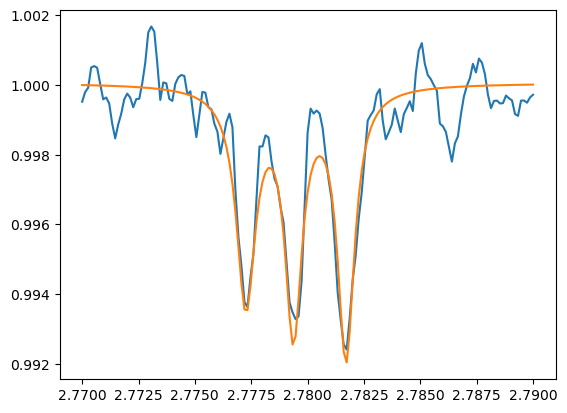

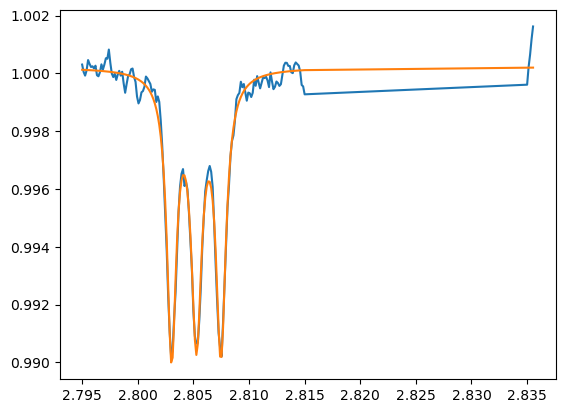

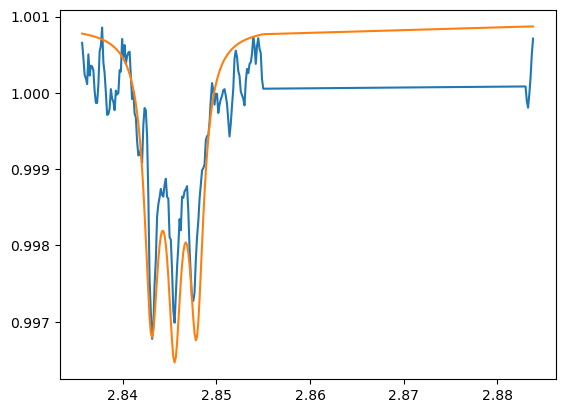

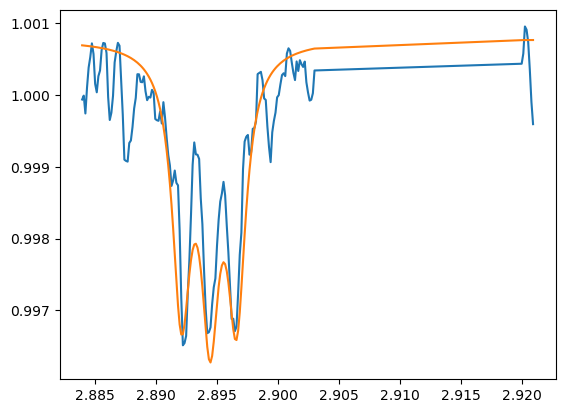

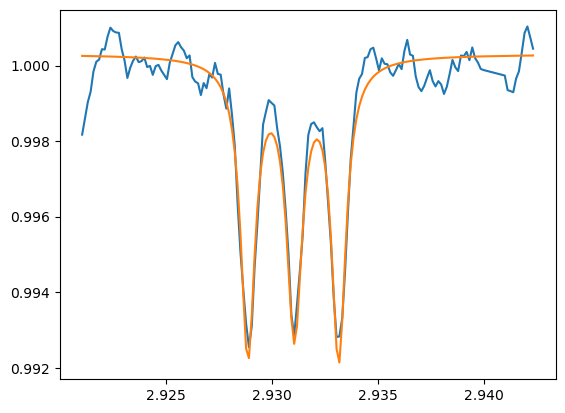

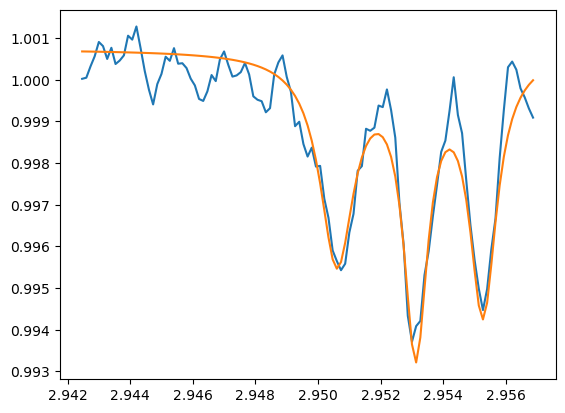

In [19]:
x_resolution = (x_data[len(x_data)-1] - x_data[0]) / len(x_data)
deltaX = 0.002 #GHz, distance from middle peak, rough estimation for initial guess 
deltaX_dat_points = (int)(deltaX / x_resolution)

B = np.zeros((x_dim, y_dim, 3))

def fit_multithreding(B_tmp, x_range, y_range, rough_estimate_peak_positions, X_source):
	peak_positions = np.zeros((x_dim, y_dim,nr_of_peaks)) 
	for i in x_range:
		for j in y_range:
			segments_data_point = np.zeros((8))
			print(i,j)
			y_data = X_source[:, i, j]
			# Calculating segments:
			for k in range(len(rough_estimate_peak_positions[i][j])):
				if k < (len(rough_estimate_peak_positions[i][j])-1) :
					segments_data_point[k+1] = (int)((rough_estimate_peak_positions[i][j][k]+rough_estimate_peak_positions[i][j][k+1])/2)
				elif k == (len(rough_estimate_peak_positions[0][0])-1):
					segments_data_point[k+1] = (int)((rough_estimate_peak_positions[i][j][k]+len(x_data))/2)
			# add last element:
			segments_data_point[7] = (int)(len(x_data))
			# Lorentzian fit for each segment
			for k in range(len(rough_estimate_peak_positions[i][j])):
				x0 = (int)(segments_data_point[k])
				x1 = (int)(segments_data_point[k+1])
	
				x_values = x_data[x0:x1]
				# x_values_tmp = [k-x0 for k in x_values]

				# y_data preparation
				y_values = y_data[x0:x1]
				y_values = savgol_filter(y_values, window_length=10, polyorder=3, mode="nearest")
		
				x = x_values
				y = -y_values
	
				rough_peak_pos_freq = (x_data[(int)(rough_estimate_peak_positions[i][j][k] - deltaX_dat_points) if (rough_estimate_peak_positions[i][j][k] - deltaX_dat_points) > 0 else 0], x_data[(int)(rough_estimate_peak_positions[i][j][k])], x_data[(int)(rough_estimate_peak_positions[i][j][k] + deltaX_dat_points if (rough_estimate_peak_positions[i][j][k] + deltaX_dat_points) < len(x_data) else len(x_data)-1)])
				multi_lorentz_fit(peak_positions, i, j, k, np.array(x), np.array(y), np.array(rough_peak_pos_freq))
			B_tmp[i][j][0] = np.abs(peak_positions[i][j][0] - peak_positions[i][j][5])
			B_tmp[i][j][1] = np.abs(peak_positions[i][j][1] - peak_positions[i][j][4])
			B_tmp[i][j][2] = np.abs(peak_positions[i][j][2] - peak_positions[i][j][3])
			print(B_tmp[i][j])

# fit_multithreding(np.arange(0,x_dim), np.arange(0,y_dim), rough_estimate_peak_positions, X)
# fit_multithreding(np.arange(0,x_dim), np.arange(0,y_dim), rough_estimate_peak_positions_mag, X_mag)
fit_multithreding(B, np.arange(12,13), np.arange(21,22), rough_estimate_peak_positions_mag, X_mag)


# [0.17353333 0.12646667 0.0492    ]